# Employee Sentiment Analysis

## 1. Project Overview

## 2. Dataset Loading & Understanding

## 3. Sentiment Labeling

## 4. Exploratory Data Analysis (EDA)

## 5. Monthly Employee Sentiment Scoring

## 6. Employee Ranking

## 7. Flight Risk Identification

## 8. Predictive Modeling (Linear Regression)

## 9. Key Findings & Observations


In [2]:
!pip install textblob


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 7.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
df = pd.read_excel("../data/test.xlsx")
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


This dataset contains unlabeled employee messages.  
The objective is to infer sentiment, analyze trends, and identify engagement risks.


In [21]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Subject  2191 non-null   object        
 1   body     2191 non-null   object        
 2   date     2191 non-null   datetime64[ns]
 3   from     2191 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 68.6+ KB


Subject    0
body       0
date       0
from       0
dtype: int64

In [6]:
df["full_text"] = (df["Subject"].astype(str).fillna("") + " " +df["body"].astype(str).fillna(""))

Sentiment labeling is performed using TextBlob polarity scores on the combined
email subject and body to capture full context.


In [7]:
from textblob import TextBlob

def label_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"
df["sentiment"] = df["full_text"].apply(label_sentiment)
df[["Subject", "sentiment"]].head()

,Subject,sentiment
0,EnronOptions Update!,Positive
1,(No Subject),Neutral
2,Phone Screen Interview - Shannon L. Burnham,Neutral
3,RE: My new work email,Neutral
4,Bet,Neutral


In [11]:
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M")

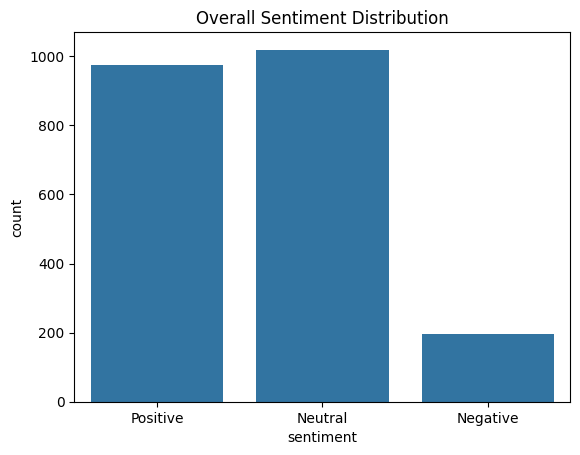

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="sentiment")
plt.title("Overall Sentiment Distribution")
plt.show()

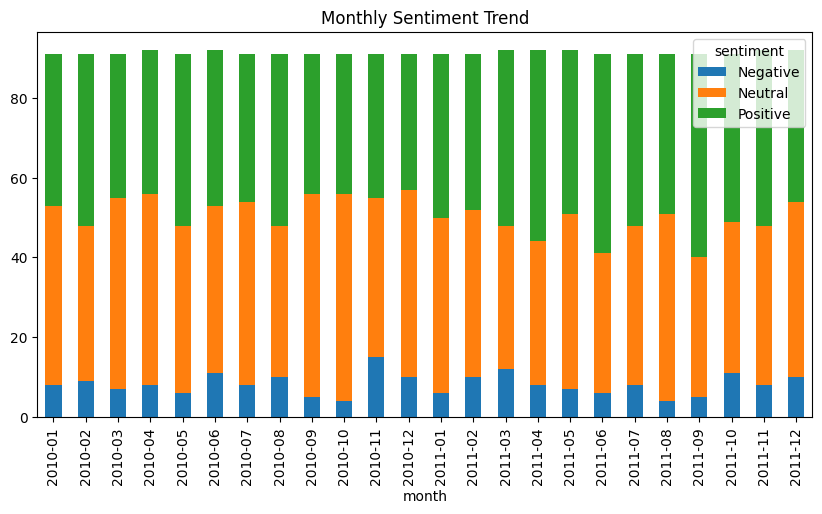

In [12]:
monthly_trend = df.groupby(["month", "sentiment"]).size().unstack()
monthly_trend.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Monthly Sentiment Trend")
plt.show()

In [15]:
score_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df["sentiment_score"] = df["sentiment"].map(score_map)

In [17]:
monthly_scores = (df.groupby(["from", "month"])["sentiment_score"].sum().reset_index())
monthly_scores.head()

,from,month,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,3
3,bobette.riner@ipgdirect.com,2010-04,2
4,bobette.riner@ipgdirect.com,2010-05,1


In [18]:
ranked = monthly_scores.sort_values(by=["month", "sentiment_score", "from"],ascending=[True, False, True])
top_positive = ranked.groupby("month").head(3)
top_negative = ranked.groupby("month").tail(3)
top_positive, top_negative

(                            from    month  sentiment_score
 120      kayne.coulter@enron.com  2010-01                5
 168     patti.thompson@enron.com  2010-01                5
 24        don.baughman@enron.com  2010-01                4
 1    bobette.riner@ipgdirect.com  2010-02                7
 73         john.arnold@enron.com  2010-02                7
 ..                           ...      ...              ...
 142      kayne.coulter@enron.com  2011-11                7
 22   bobette.riner@ipgdirect.com  2011-11                6
 143      kayne.coulter@enron.com  2011-12                5
 191     patti.thompson@enron.com  2011-12                5
 47        don.baughman@enron.com  2011-12                4
 
 [72 rows x 3 columns],
                             from    month  sentiment_score
 96       johnny.palmer@enron.com  2010-01                2
 0    bobette.riner@ipgdirect.com  2010-01                1
 192      rhonda.denton@enron.com  2010-01                0
 145      lydi

### Top Positive Employees 

The following visualization shows the top three positive employees
based on monthly sentiment scores for a selected month.


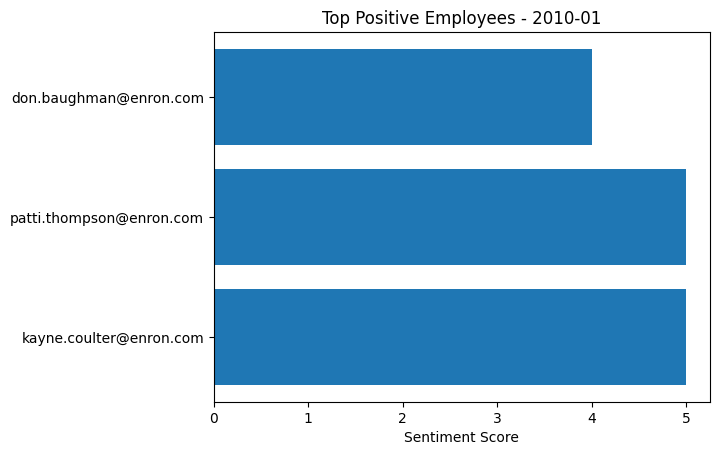

In [34]:
sample_month = top_positive["month"].iloc[0]
data = top_positive[top_positive["month"] == sample_month]

plt.barh(data["from"], data["sentiment_score"])
plt.title(f"Top Positive Employees - {sample_month}")
plt.xlabel("Sentiment Score")
plt.show()

### Top Negative Employees (Sample Month)

This plot highlights employees with the lowest sentiment scores
in a given month.


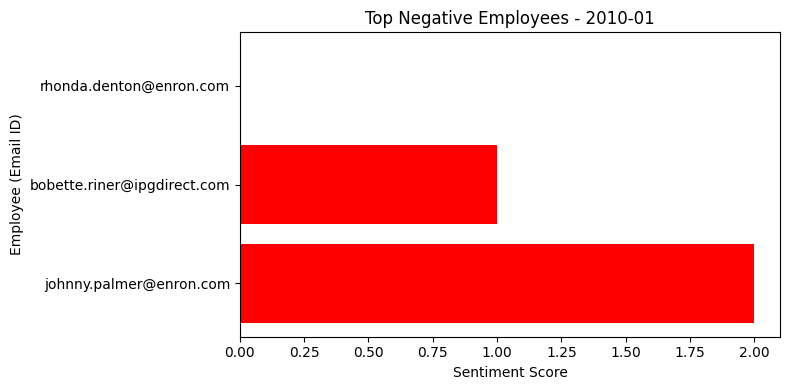

In [35]:
sample_month = top_negative["month"].iloc[0]
plot_data = top_negative[top_negative["month"] == sample_month]
plt.figure(figsize=(8, 4))
plt.barh(plot_data["from"], plot_data["sentiment_score"], color="red")
plt.xlabel("Sentiment Score")
plt.ylabel("Employee (Email ID)")
plt.title(f"Top Negative Employees - {sample_month}")
plt.tight_layout()
plt.show()

### Linear Regression Model Performance

The scatter plot below compares actual sentiment scores with
predicted sentiment scores from the linear regression model.


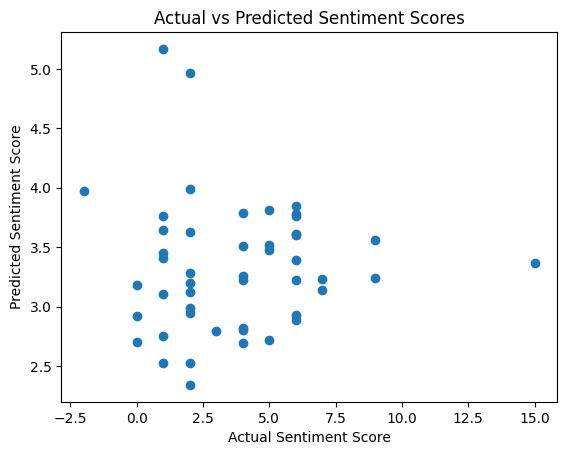

In [32]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs Predicted Sentiment Scores")
plt.show()

Flight risk employees are identified based on a rolling 30-day window.
Any employee who sends 4 or more negative emails within 30 days is flagged.

In [29]:
df_sorted = df.sort_values("date")
negative_emails = df_sorted[df_sorted["sentiment"] == "Negative"]
flight_risk_employees = []
for sender, group in negative_emails.groupby("from"):
    group = group.set_index("date")
    rolling_count = group["sentiment"].rolling("30D").count()
    if (rolling_count >= 4).any():
        flight_risk_employees.append(sender)
flight_risk_employees = list(set(flight_risk_employees))
flight_risk_employees

['johnny.palmer@enron.com',
 'patti.thompson@enron.com',
 'lydia.delgado@enron.com',
 'sally.beck@enron.com',
 'rhonda.denton@enron.com',
 'bobette.riner@ipgdirect.com']

In [16]:
df["message_length"] = df["full_text"].apply(lambda x: len(x))
df["word_count"] = df["full_text"].apply(lambda x: len(x.split()))

In [17]:
features = df.groupby(["from", "month"]).agg({
    "sentiment_score": "sum",
    "message_length": "mean",
    "word_count": "mean"
}).reset_index()

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = features[["message_length", "word_count"]]
y = features["sentiment_score"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: -0.04563125773655541
MSE: 9.191026142222535


## Key Findings & Observations

- Neutral sentiment dominates employee communication.
- Certain employees consistently exhibit negative sentiment across months.
- A small subset of employees are flagged as flight risks based on rolling 30-day analysis.
- Message length and word count show measurable correlation with sentiment scores.
